# 파이토치 CIFAR10 모델
- 코드 출처: https://tutorials.pytorch.kr/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py

## modules import

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

- 현재 GPU 설정

In [18]:
use_cuda = torch.torch.cuda.is_available()

device = torch.device('cuda' if use_cuda else 'cpu')

In [16]:
device

device(type='cuda')

## 전처리 설정

In [19]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

## 데이터 로드 및 확인

In [ ]:
train_set = torchvision.datasets.CIFAR10(root = '/data',
                                          train = True,
                                          download = True,
                                          transform = transform)

test_set = torchvision.datasets.CIFAR10(root = '/data',
                                          train = False,
                                          download = True,
                                          transform = transform)

train_loader = DataLoader(train_set, batch_size = 4,shuffle = True, num_workers = 2)
test_loader = DataLoader(test_set, batch_size = 4,shuffle = False, num_workers = 2)

In [22]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

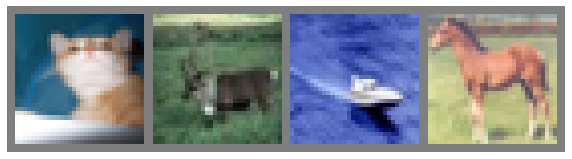

cat	deer	ship	horse	


In [27]:
def imshow(img):
  img = img / 2 +0.5
  npimg = img.numpy()
  plt.figure(figsize =(10, 5))
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.axis('off')
  plt.show()

dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(''.join('{}\t'.format(classes[labels[j]]) for j in range(4)))

## 신경망 구성

In [28]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()

    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16*5*5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))  
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16*5*5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))

    return x
  
net = Net().to(device)

## 손실함수와 옵티마이저

In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)

## 모델 학습

- 설명을 위해 `epochs=2`로 지정

In [30]:
for epoch in range(2):
  running_loss = 0.0
  
  for i, data in enumerate(train_loader, 0):
    inputs, labels = data[0].to(device), data[1].to(device)

    optimizer.zero_grad()

    outputs = net(inputs)

    loss = criterion(outputs, labels)
    loss.backward()

    optimizer.step()

    running_loss += loss.item()

    if i % 2000 == 1999:
      print('Epoch: {}, Batch: {}, Loss: {}'.format(epoch +1 , i+1, running_loss / 2000))
      running_loss = 0.0

Epoch: 1, Batch: 2000, Loss: 2.2514349009394645
Epoch: 1, Batch: 4000, Loss: 2.074955172508955
Epoch: 1, Batch: 6000, Loss: 1.8771888615190984
Epoch: 1, Batch: 8000, Loss: 1.6789787055253982
Epoch: 1, Batch: 10000, Loss: 1.5760718459188938
Epoch: 1, Batch: 12000, Loss: 1.4944578644782305
Epoch: 2, Batch: 2000, Loss: 1.4280191742032766
Epoch: 2, Batch: 4000, Loss: 1.413764538191259
Epoch: 2, Batch: 6000, Loss: 1.358924875535071
Epoch: 2, Batch: 8000, Loss: 1.3385411043092608
Epoch: 2, Batch: 10000, Loss: 1.3198892043605446
Epoch: 2, Batch: 12000, Loss: 1.2712115108557045


## 모델의 저장 및 로드

In [31]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

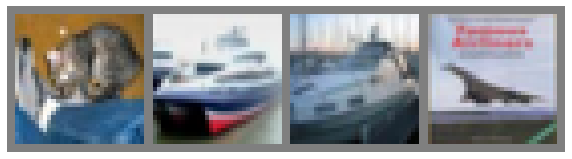

cat	   ship	   ship	   plane	


In [35]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('   '.join('{}\t'.format(classes[labels[j]]) for j in range(4)))

In [38]:
net = Net().to(device)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## 모델 테스트

In [40]:
outputs = net(images.to(device))

In [43]:
_, predicted = torch.max(outputs, 1)
print(' '.join('\t{}'.format(classes[predicted[j]]) for j in range(4)))

	cat 	car 	truck 	ship


In [45]:
correct = 0
total = 0

with torch.no_grad():
  for data in test_loader:
    images, labels = data[0].to(device), data[1].to(device)
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(100 * correct / total)

54.85


- 어떤 것을 잘 분류했고, 잘 못했는지 확인

In [48]:
class_coreect = list(0 for i in range(10))
class_total = list(0 for i in range(10))

with torch.no_grad():
  for data in test_loader:
    images, labels = data[0].to(device), data[1].to(device)
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
      label = labels[i]
      class_coreect[label] += c[i].item()
      class_total[label] += 1

  for i in range(10):
    print('accuracy of {}: {}%'.format(classes[i], 100*class_coreect[i] / class_total[i]))



accuracy of plane: 50.4%
accuracy of car: 49.2%
accuracy of bird: 28.2%
accuracy of cat: 39.6%
accuracy of deer: 60.1%
accuracy of dog: 41.7%
accuracy of frog: 63.7%
accuracy of horse: 68.7%
accuracy of ship: 66.8%
accuracy of truck: 80.1%
